In [1]:
from google.colab import files

# Upload from your computer
uploaded = files.upload()

Saving milstone 2.zip to milstone 2.zip


In [2]:
import zipfile, os

zip_path = "/content/milstone 2.zip"   # change path if needed
extract_path = "/content/millstone"

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

In [3]:
import zipfile, os

if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"✅ Extracted to {extract_path}")
else:
    print("❌ ZIP not found. Please upload Hima.zip to Google Drive > MyDrive")

✅ Extracted to /content/millstone


In [4]:
!pip install torch torchvision --quiet
!pip install Pillow tqdm --quiet

In [9]:
import os, random, glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.transforms.functional import to_pil_image

In [10]:
# ===============================
# Dataset
# ===============================
class PairedSRDataset(Dataset):
    def __init__(self, hr_folder, scale=2, patch_size=64, augment=True):
        self.hr_paths = sorted(glob.glob(os.path.join(hr_folder, '*')))
        self.scale = scale
        self.ps = patch_size
        self.augment = augment
        self.to_tensor = T.ToTensor()

    def __len__(self):
        return len(self.hr_paths)

    def __getitem__(self, idx):
        hr = Image.open(self.hr_paths[idx]).convert('RGB')
        w, h = hr.size

        # Bicubic down+up
        lr = hr.resize((w//self.scale, h//self.scale), Image.BICUBIC)
        lr = lr.resize((w, h), Image.BICUBIC)

        # Random crop
        if self.ps:
            x = random.randint(0, w - self.ps)
            y = random.randint(0, h - self.ps)
            hr = hr.crop((x, y, x + self.ps, y + self.ps))
            lr = lr.crop((x, y, x + self.ps, y + self.ps))

        # Augment
        if self.augment and random.random() < 0.5:
            hr = hr.transpose(Image.FLIP_LEFT_RIGHT)
            lr = lr.transpose(Image.FLIP_LEFT_RIGHT)

        return self.to_tensor(lr), self.to_tensor(hr)

In [11]:
# ===============================
# SRCNN Model
# ===============================
class SRCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [12]:
# ===============================
# Training Function
# ===============================
def train_epoch(model, loader, opt, criterion, device):
    model.train()
    running = 0.0
    pbar = tqdm(loader)
    for lr, hr in pbar:
        lr, hr = lr.to(device), hr.to(device)
        pred = model(lr)
        loss = criterion(pred, hr)

        opt.zero_grad()
        loss.backward()
        opt.step()

        running += loss.item()
        pbar.set_description(f"loss={loss.item():.4f}")

    return running / len(loader)



In [13]:
# ===============================
# Training Loop
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

HR_FOLDER = "/content/millstone/milstone 2/train"
SAVE_MODEL_FOLDER = "/content/results/models"
SAVE_IMG_FOLDER = "/content/results/comparisons"

os.makedirs(SAVE_MODEL_FOLDER, exist_ok=True)
os.makedirs(SAVE_IMG_FOLDER, exist_ok=True)

dataset = PairedSRDataset(HR_FOLDER, scale=2, patch_size=64, augment=True)
loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)

model = SRCNN().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.L1Loss()

for epoch in range(1, 12):
    loss = train_epoch(model, loader, opt, criterion, device)
    print(f"Epoch {epoch}, Avg Loss = {loss:.4f}")
    torch.save(model.state_dict(), os.path.join(SAVE_MODEL_FOLDER, f"srcnn_epoch{epoch}.pth"))

  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
loss=0.4982: 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]


Epoch 1, Avg Loss = 0.4826


loss=0.4614: 100%|██████████| 3/3 [00:01<00:00,  2.71it/s]


Epoch 2, Avg Loss = 0.4475


loss=0.3736: 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


Epoch 3, Avg Loss = 0.4148


loss=0.4480: 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]


Epoch 4, Avg Loss = 0.4419


loss=0.3545: 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]


Epoch 5, Avg Loss = 0.4030


loss=0.3602: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Epoch 6, Avg Loss = 0.3722


loss=0.3218: 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]


Epoch 7, Avg Loss = 0.3530


loss=0.2413: 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]


Epoch 8, Avg Loss = 0.3128


loss=0.2815: 100%|██████████| 3/3 [00:00<00:00,  3.13it/s]


Epoch 9, Avg Loss = 0.2685


loss=0.2138: 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]


Epoch 10, Avg Loss = 0.2408


loss=0.1567: 100%|██████████| 3/3 [00:00<00:00,  3.05it/s]

Epoch 11, Avg Loss = 0.1748


In [15]:
# ===============================
# Inference + Comparison Saving
# ===============================
TEST_FOLDER = "/content/millstone/milstone 2/test"

# Load best model (last epoch here)
model = SRCNN()
model.load_state_dict(torch.load(os.path.join(SAVE_MODEL_FOLDER, "srcnn_epoch10.pth"), map_location="cpu"))
model.eval()

files = [f for f in os.listdir(TEST_FOLDER) if os.path.isfile(os.path.join(TEST_FOLDER, f))]

for file in files:
    path = os.path.join(TEST_FOLDER, file)

    # Load HR
    img = Image.open(path).convert("RGB")
    w, h = img.size

    # Bicubic LR
    lr = img.resize((w//2, h//2), Image.BICUBIC).resize((w, h), Image.BICUBIC)

    # SRCNN inference
    x = T.ToTensor()(lr).unsqueeze(0)
    with torch.no_grad():
        y = model(x)
    out = to_pil_image(torch.clamp(y[0], 0, 1))

    # Save enhanced
    out.save(os.path.join(SAVE_IMG_FOLDER, f"enhanced_{file}"))

    # Save comparison figure
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original HR")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(lr)
    plt.title("Bicubic LR")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(out)
    plt.title("SRCNN Enhanced")
    plt.axis("off")

    plt.suptitle(f"Comparison for: {file}", fontsize=14)
    plt.savefig(os.path.join(SAVE_IMG_FOLDER, f"comparison_{file}"))
    plt.close()

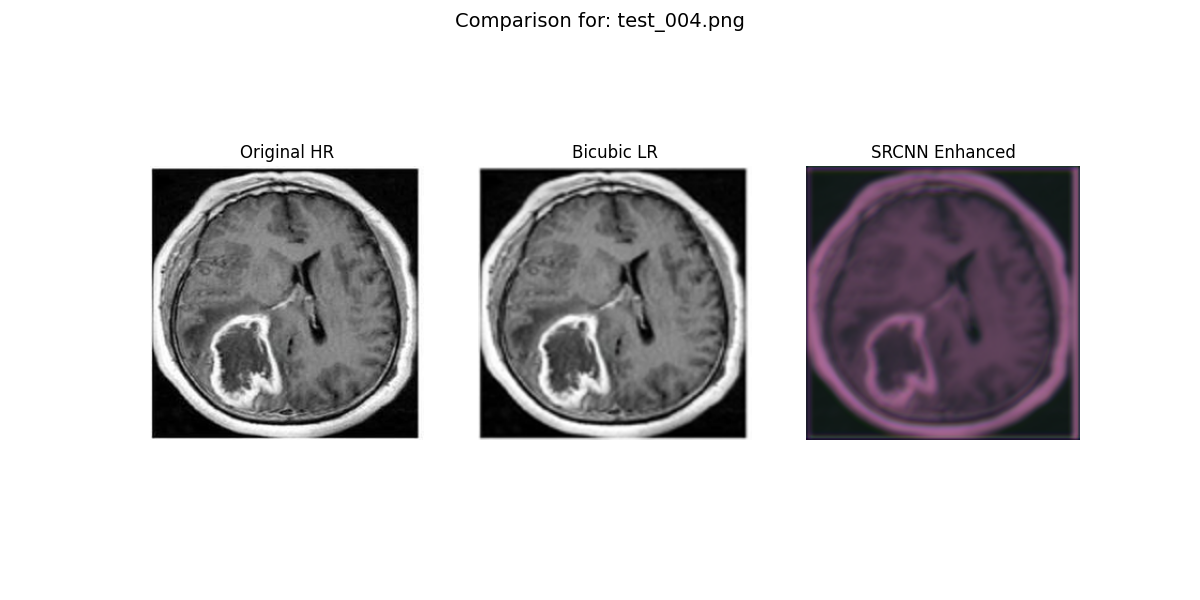

In [18]:
from IPython.display import Image, display

# Show one saved comparison image
display(Image(filename=os.path.join(SAVE_IMG_FOLDER, f"comparison_{files[5]}")))


In [21]:
import shutil
from google.colab import files

# Path to the results folder
results_folder = "/content/results"

# Create a zip archive of the entire results folder
zip_path = "/content/results.zip"
shutil.make_archive("/content/results", 'zip', results_folder)

print(f"✅ Zipped folder saved at: {zip_path}")

# Trigger download
files.download(zip_path)



✅ Zipped folder saved at: /content/results.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>